In [1]:

from textwrap import wrap
import shutil
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import os, warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import random

print('TensorFlow Version ' + tf.__version__)


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


seed_everything()

import warnings

warnings.filterwarnings("ignore")

TensorFlow Version 2.10.0


In [4]:
image_size = 224
batch_size = 16
n_classes = 3
EPOCHS = 40

train_path = 'class-dataset/train'
valid_path = 'class-dataset/valid'
test_path = 'class-dataset/test'

classes = {0: "Dry",
           1: "Normal",
           2: "Wet"}

In [5]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float16)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float16)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float16)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float16)

    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if p_spatial > .75:
        image = tf.image.transpose(image)

    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3)  # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2)  # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1)  # rotate 90º

    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)

    return image

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                                samplewise_center=True,
                                                                samplewise_std_normalization=True,
                                                                preprocessing_function = data_augment,
                                                                dtype='float16')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                               samplewise_center=True,
                                                               samplewise_std_normalization=True,
                                                               dtype='float16')

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                                samplewise_center=True,
                                                                samplewise_std_normalization=True,
                                                                dtype='float16')

train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode='categorical',
    subset='training')

# same directory as training data

valid_gen = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=1,
    shuffle=False,
    class_mode='categorical',
)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    seed=1,
    shuffle=False,
    class_mode='categorical',
)
class_indices_mapping = train_gen.class_indices

Found 2266 images belonging to 3 classes.
Found 287 images belonging to 3 classes.
Found 281 images belonging to 3 classes.


In [8]:
from sklearn.utils import class_weight

train_labels = []
for i in range(len(train_gen)):
    _, labels = train_gen[i]
    train_labels.extend(np.argmax(labels, axis=1))

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))

In [6]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [11]:
plt.figure(figsize=(4, 4))
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


<Figure size 400x400 with 0 Axes>

Error in callback <function flush_figures at 0x00000164FE1EB5E0> (for post_execute):


KeyboardInterrupt: 

In [7]:
from vit_keras import vit

vit_model = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=200)

In [8]:
model = tf.keras.Sequential([
    vit_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation=tf.keras.activations.gelu),
    tf.keras.layers.Dense(3, 'softmax')
],
    name='vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 200)               85952456  
                                                                 
 flatten (Flatten)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 128)               25728     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                

In [9]:
warnings.filterwarnings("ignore")

learning_rate = 1e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              metrics=['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
filepath = "checkpoints/categorical-model-{epoch:02d}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                                               save_best_only=False, save_weights_only=False,
                                                               mode='auto', period=1)

History = model.fit(x=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    callbacks=[early_stopping_callbacks, model_checkpoint_callback],
                    class_weight=class_weights_dict)

model.save("models/categorical.h5")

Epoch 1/50
173/173 [==============================] - 57s 244ms/step - loss: 1.0740 - accuracy: 0.3241 - val_loss: 1.1002 - val_accuracy: 0.1875
Epoch 2/50
173/173 [==============================] - 40s 229ms/step - loss: 0.9767 - accuracy: 0.3575 - val_loss: 1.0963 - val_accuracy: 0.5000
Epoch 3/50
173/173 [==============================] - 40s 229ms/step - loss: 0.9241 - accuracy: 0.3666 - val_loss: 0.9958 - val_accuracy: 0.6875
Epoch 4/50
173/173 [==============================] - 40s 231ms/step - loss: 0.8680 - accuracy: 0.3695 - val_loss: 0.8987 - val_accuracy: 0.5625
Epoch 5/50
173/173 [==============================] - 40s 231ms/step - loss: 0.7978 - accuracy: 0.3640 - val_loss: 0.8500 - val_accuracy: 0.5625
Epoch 6/50
173/173 [==============================] - 39s 227ms/step - loss: 0.8022 - accuracy: 0.3825 - val_loss: 0.8628 - val_accuracy: 0.6250
Epoch 7/50
173/173 [==============================] - 40s 229ms/step - loss: 0.7646 - accuracy: 0.3956 - val_loss: 0.8323 - val_ac

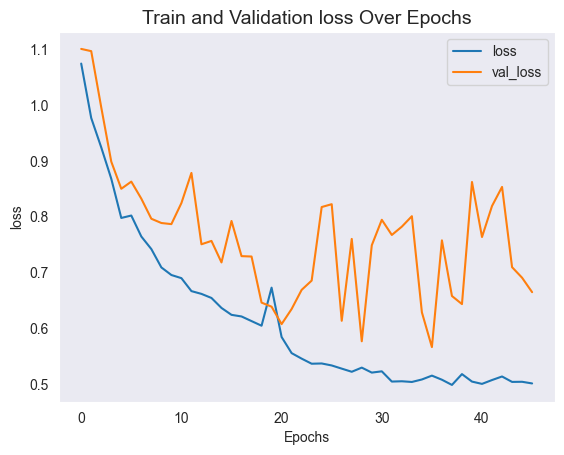

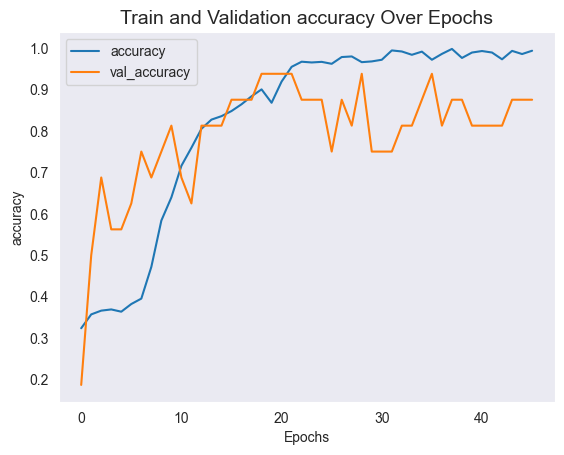

In [10]:
def plot_history(item):
    plt.plot(History.history[item], label=item)
    plt.plot(History.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

2/2 [==============================] - 3s 103ms/step
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.82      0.90      0.86        10
           2       1.00      0.30      0.46        10

    accuracy                           0.70        30
   macro avg       0.79      0.70      0.67        30
weighted avg       0.79      0.70      0.67        30


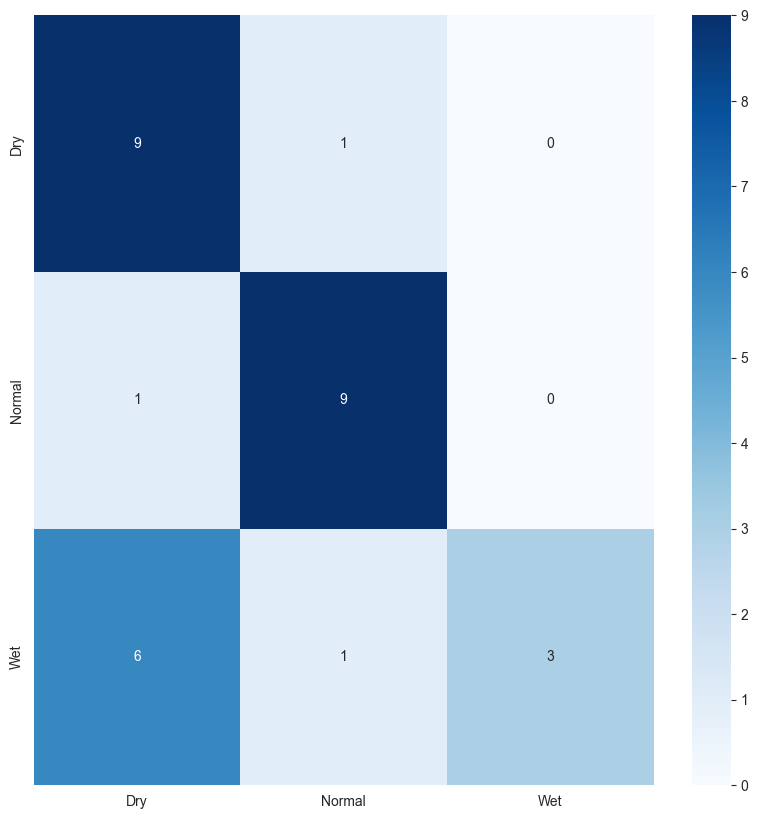

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predicted_classes = np.argmax(model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1), axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(confusionmatrix, cmap='Blues', annot=True, cbar=True, fmt='g', xticklabels=class_labels,
            yticklabels=class_labels)

print(classification_report(true_classes, predicted_classes))